<a href="https://colab.research.google.com/github/gowrisankar393/vaylen-transitlk/blob/Multi-Sensor-Fusion-Crash-Detection/TransitLK_MSFCD_SDP_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Import Packges and Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#upload file
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
df.head()


Saving nthsc_telemetry_records.csv to nthsc_telemetry_records (6).csv


,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,gps_lat,gps_lon,gps_speed,obd_speed,pressure_front_left,pressure_front_right,pressure_front_center,crash_label
0,00:00.0,0.048821,-0.011172,9.728132,-0.059900,0.025932,0.029532,6.927066,79.861257,33.415314,33.867092,-0.103833,-0.090546,-0.166289,0
1,00:00.1,-0.322199,0.010574,9.847846,0.039173,-0.000310,0.008598,6.927082,79.861172,36.723372,36.748822,-0.022638,-0.120503,0.110570,0
2,00:00.2,-0.053862,-0.116964,9.931771,-0.047428,0.049054,-0.000810,6.927029,79.861224,32.838589,33.401953,0.021689,-0.153968,-0.125656,0
3,00:00.3,0.110942,0.055344,9.806929,0.018462,-0.014612,-0.033265,6.927110,79.861229,34.966767,34.646854,-0.205877,-0.139806,-0.120319,0
4,00:00.4,-0.216046,-0.044886,9.828593,0.001573,0.047886,-0.016735,6.927106,79.861151,41.190249,41.295906,0.058183,-0.027598,-0.042948,0


##**Exploratory Data Analysis**

In [ ]:
print("Shape:", df.shape) #number of rows
print("\nColumns:", df.columns.tolist()) #columns
print("\nMissing values:\n", df.isna().sum()) #missing values
print("\nCrash label counts:\n", df['crash_label'].value_counts()) #crash and non crash samples count


Shape: (6000, 15)

Columns: ['timestamp', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gps_lat', 'gps_lon', 'gps_speed', 'obd_speed', 'pressure_front_left', 'pressure_front_right', 'pressure_front_center', 'crash_label']

Missing values:
 timestamp                0
accel_x                  0
accel_y                  0
accel_z                  0
gyro_x                   0
gyro_y                   0
gyro_z                   0
gps_lat                  0
gps_lon                  0
gps_speed                0
obd_speed                0
pressure_front_left      0
pressure_front_right     0
pressure_front_center    0
crash_label              0
dtype: int64

Crash label counts:
 crash_label
0    5840
1     160
Name: count, dtype: int64


##**Feature  Extraction**

In [ ]:
#resultant acceleration
df['accel_res'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)

#resultant angular velocity (rotation)
df['gyro_res']  = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)

#jerk (rate of change of acceleration)
df['jerk_x'] = df['accel_x'].diff()
df['jerk_y'] = df['accel_y'].diff()
df['jerk_z'] = df['accel_z'].diff()
df['jerk_res'] = df['accel_res'].diff()

#speed change (delta speed)
df['delta_speed'] = df['gps_speed'].diff()

#total pressure in front bumper
df['pressure_sum'] = (
    df['pressure_front_left'] +
    df['pressure_front_right'] +
    df['pressure_front_center']
)

#short time energy (STE) of crash
df['ste_accel'] = df['accel_res'] ** 2

df = df.fillna(0)
df.head()


,timestamp,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,gps_lat,gps_lon,gps_speed,...,crash_label,accel_res,gyro_res,jerk_x,jerk_y,jerk_z,jerk_res,delta_speed,pressure_sum,ste_accel
0,00:00.0,0.048821,-0.011172,9.728132,-0.059900,0.025932,0.029532,6.927066,79.861257,33.415314,...,0,9.728261,0.071642,0.000000,0.000000,0.000000,0.000000,0.000000,-0.360668,94.639052
1,00:00.1,-0.322199,0.010574,9.847846,0.039173,-0.000310,0.008598,6.927082,79.861172,36.723372,...,0,9.853121,0.040107,-0.371020,0.021746,0.119714,0.124860,3.308058,-0.032571,97.083993
2,00:00.2,-0.053862,-0.116964,9.931771,-0.047428,0.049054,-0.000810,6.927029,79.861224,32.838589,...,0,9.932606,0.068237,0.268337,-0.127539,0.083925,0.079485,-3.884783,-0.257935,98.656665
3,00:00.3,0.110942,0.055344,9.806929,0.018462,-0.014612,-0.033265,6.927110,79.861229,34.966767,...,0,9.807713,0.040754,0.164805,0.172308,-0.124842,-0.124893,2.128178,-0.466002,96.191234
4,00:00.4,-0.216046,-0.044886,9.828593,0.001573,0.047886,-0.016735,6.927106,79.861151,41.190249,...,0,9.831070,0.050751,-0.326988,-0.100230,0.021664,0.023357,6.223482,-0.012363,96.649929


##**XGBoost Model**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

features = [
    'accel_x','accel_y','accel_z',
    'accel_res','gyro_res',
    'jerk_x','jerk_y','jerk_z','jerk_res',
    'gps_speed','delta_speed',
    'pressure_sum','ste_accel'
]

X = df[features]
y = df['crash_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

##**Model Evaluation**

In [ ]:
y_pred = model.predict(X_test)

print("Classification Report - MSFCD Sensor Data")
print(classification_report(y_test, y_pred))


Classification Report - MSFCD Sensor Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1168
           1       1.00      1.00      1.00        32

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



##**Confusion Matrix**

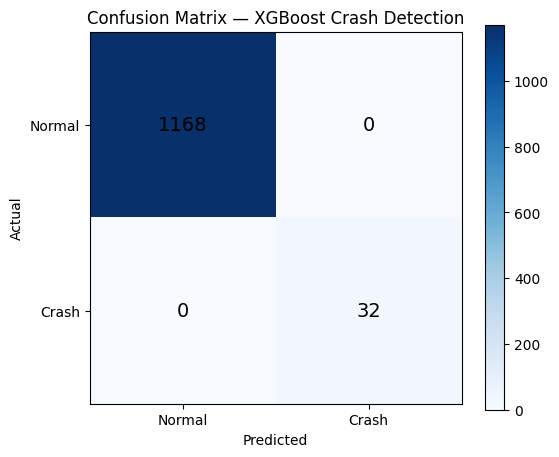

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — XGBoost Crash Detection")
plt.colorbar()

#axis
plt.xticks([0,1], ["Normal", "Crash"])
plt.yticks([0,1], ["Normal", "Crash"])

#values inside the matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=14)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


##**Feature Importance**

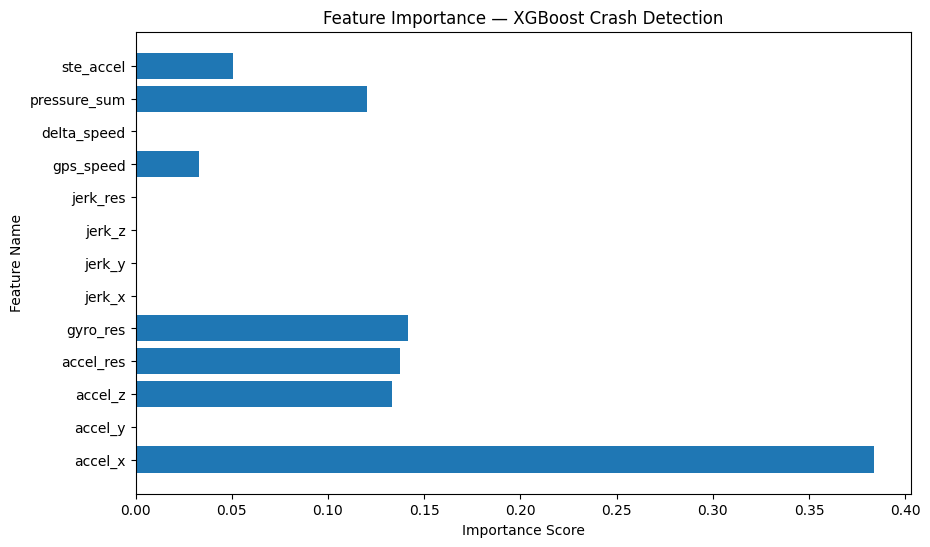

In [ ]:
importances = model.feature_importances_

plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.title("Feature Importance — XGBoost Crash Detection")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()


##**Saving Model as a pkl file**

In [ ]:
joblib.dump(model, "xgboost_crash_model.pkl")


['xgboost_crash_model.pkl']

##**Sample Working Program with the Model**

####In real life the model will  work with sensor data given by the system every 3-5s. For testing purposes we're giving data manually and cheking

In [ ]:
import joblib
import numpy as np
import pandas as pd
import time
import threading

#load the XGBoost model
model = joblib.load("xgboost_crash_model.pkl")

feature_cols = [
    'accel_x','accel_y','accel_z',
    'accel_res','gyro_res',
    'jerk_x','jerk_y','jerk_z','jerk_res',
    'gps_speed','delta_speed',
    'pressure_sum','ste_accel'
]

previous = None
driver_response = None

def ask_driver():
    #collect driver response
    global driver_response
    driver_response = input("\nDriver, are you okay? (y/n): ").strip().lower()


print("\nTransitLK MSFCD")

while True:
    start = input("\nPress Enter to input sensor data (or type 'exit'): ")
    if start.lower() == "exit":
        break

    #sensor input
    accel_x = float(input("accel_x: "))
    accel_y = float(input("accel_y: "))
    accel_z = float(input("accel_z: "))
    gyro_x = float(input("gyro_x: "))
    gyro_y = float(input("gyro_y: "))
    gyro_z = float(input("gyro_z: "))
    gps_speed = float(input("gps_speed: "))
    p_l = float(input("pressure_front_left: "))
    p_r = float(input("pressure_front_right: "))
    p_c = float(input("pressure_front_center: "))

    #feature extraction
    accel_res = np.sqrt(accel_x**2 + accel_y**2 + accel_z**2)
    gyro_res  = np.sqrt(gyro_x**2 + gyro_y**2 + gyro_z**2)
    pressure_sum = p_l + p_r + p_c
    ste_accel = accel_res ** 2

    if previous is None:
        jerk_x = jerk_y = jerk_z = jerk_res = 0
        delta_speed = 0
    else:
        jerk_x = accel_x - previous['accel_x']
        jerk_y = accel_y - previous['accel_y']
        jerk_z = accel_z - previous['accel_z']
        jerk_res = accel_res - previous['accel_res']
        delta_speed = gps_speed - previous['gps_speed']

    row = pd.DataFrame([[
        accel_x, accel_y, accel_z,
        accel_res, gyro_res,
        jerk_x, jerk_y, jerk_z, jerk_res,
        gps_speed, delta_speed,
        pressure_sum, ste_accel
    ]], columns=feature_cols)

    #prediction
    pred = model.predict(row)[0]
    prob = model.predict_proba(row)[0][1]

    print("\nTRANSITLK MULTI SENSOR FUSION CRASH DETECTION ALERT")
    if pred == 1:
        print("Crash Detected!")
        print(f"Crash Probability = {prob:.4f}")
        print("\nWaiting for driver confirmation (7 seconds)…")

        driver_response = None
        t = threading.Thread(target=ask_driver)
        t.start()

        for i in range(7, 0, -1):
            print(f"{i}.. ", end="", flush=True)
            time.sleep(1)
        print()

        if driver_response in ["y", "yes"]:
            print("False alarm — Driver confirms safety")
        else:
            print("No driver response!")
            print("Contacting emergency services (1990/Police)")
            print("Sending GPS + crash data")
    else:
        print("Normal")
        print(f"Crash Probability = {prob:.4f}")

    previous = {
        "accel_x": accel_x,
        "accel_y": accel_y,
        "accel_z": accel_z,
        "accel_res": accel_res,
        "gps_speed": gps_speed
    }



TransitLK MSFCD

Press Enter to input sensor data (or type 'exit'): 
accel_x: -10
accel_y: -20
accel_z: -5
gyro_x: 0.3
gyro_y: 0.5
gyro_z: 0.6
gps_speed: 50
pressure_front_left: 0.1
pressure_front_right: 0.1
pressure_front_center: 0.1

TRANSITLK MULTI SENSOR FUSION CRASH DETECTION ALERT
Crash Detected!
Crash Probability = 0.7590

Waiting for driver confirmation (7 seconds)…
7.. 6.. 5.. 4.. 3.. 2.. 1.. 
No driver response!
Contacting emergency services (1990/Police)
Sending GPS + crash data

Press Enter to input sensor data (or type 'exit'): 

Driver, are you okay? (y/n): n
